In [6]:
import numpy as np
import module

def compute_proxy_nodes(states, goal_nodes, num_proxy_nodes):
    """
    Compute proxy nodes by selecting nodes that maximize temporal correlation with the goal nodes.

    Parameters
    ----------
    states : np.ndarray
        Array of reservoir states over time (shape: [time_steps, num_nodes]).
    goal_nodes : array-like
        Indices of the goal nodes.
    num_proxy_nodes : int
        Number of proxy nodes to select.

    Returns
    -------
    np.ndarray
        Indices of the selected proxy nodes.
    """
    # Compute the average time series of the goal nodes
    goal_time_series = np.mean(states[:, goal_nodes], axis=1)

    # Compute correlation of each node with the goal time series
    correlations = []
    for node in range(states.shape[1]):
        node_time_series = states[:, node]
        correlation = np.corrcoef(goal_time_series, node_time_series)[0, 1]
        correlations.append(correlation)

    # Sort nodes by correlation in descending order and select top nodes
    sorted_indices = np.argsort(correlations)[::-1]
    proxy_nodes = sorted_indices[:num_proxy_nodes]

    return proxy_nodes

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_proxy_nodes_from_esn(esn, agent_nodes, goal_nodes, num_proxy_nodes, num_random_actions=10, steps=500, discard=100, inverse=False, plot=False):  
    """
    Compute proxy nodes by selecting nodes that maximize temporal correlation with the goal nodes.
    Generates multiple random agent actions to test correlations.

    Parameters
    ----------
    esn : EchoStateNetwork
        Instance of the Echo State Network.
    agent_nodes : array-like
        Indices of nodes controlled by the agent.
    goal_nodes : array-like
        Indices of the goal nodes.
    num_proxy_nodes : int
        Number of proxy nodes to select.
    num_random_actions : int, optional
        Number of random agent action sets to generate, by default 10.
    steps : int, optional
        Number of steps to run the ESN for each random action set, by default 500.
    discard : int, optional
        Number of initial steps to discard (transient period), by default 100.

    Returns
    -------
    np.ndarray
        Indices of the selected proxy nodes.
    """
    
    num_nodes = esn.n
    possible_nodes =  [i for i in range(num_nodes) if i not in agent_nodes and i not in goal_nodes]
    correlations = np.zeros(num_nodes)
    avg_goal_values = []
    for _ in range(num_random_actions):
        # Generate random agent actions
        agent_values = np.random.choice([-1.0, 0.0, 1.0], size=len(agent_nodes))

        # Run the ESN with the random agent actions
        states = esn.run(steps=steps, discard=discard, agent_nodes=agent_nodes, agent_values=agent_values)

        # Compute the average time series of the goal nodes
        goal_time_series = np.mean(states[:, goal_nodes], axis=1)

        # Compute correlation of each node with the goal time series
        for node in possible_nodes:
            node_time_series = states[:, node]
            correlation = np.corrcoef(goal_time_series, node_time_series)[0, 1]
            correlations[node] += correlation
        avg_goal_values.append(np.mean(goal_time_series))
        

    # Average the correlations over all random actions
    correlations /= num_random_actions
    

    # Sort nodes by correlation in descending order and select top nodes
    sorted_indices = np.argsort(correlations)[::-1 + 2*inverse]
    proxy_nodes = sorted_indices[:num_proxy_nodes]
    #print("corr_before",correlations[proxy_nodes])

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(states[:, proxy_nodes], label ='Proxy Nodes')
        plt.plot(states[:, goal_nodes], label ='Goal Nodes', linestyle='--')
        plt.title('Node Correlations with Goal Nodes')
        plt.xlabel('temporal steps')
        plt.ylabel('Correlation Coefficient')
        plt.legend()
        plt.grid()
        plt.show()

    #print("goal base", np.mean(avg_goal_values))
    #print("example proxy ",[np.mean(states[:, node]) for node in proxy_nodes])
    goal_value = np.mean(avg_goal_values)
    return proxy_nodes, goal_value

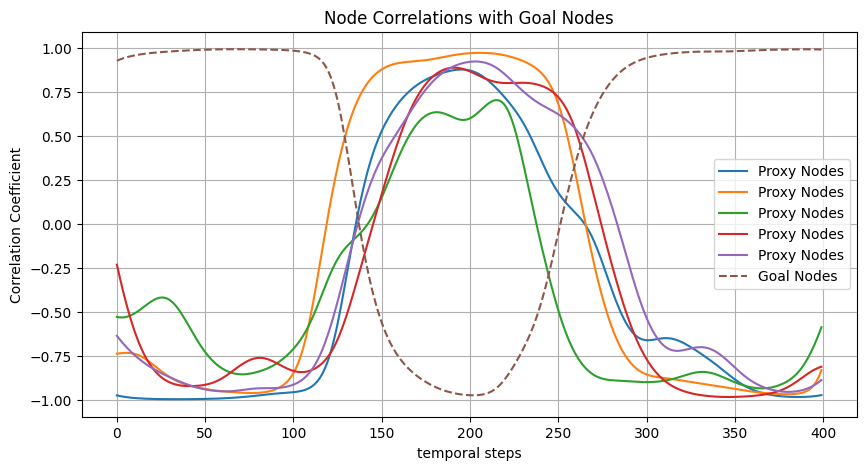

Selected proxy nodes: [350 245  59 469 403]


In [8]:
# Example parameters
n = 100  # Total nodes
k = 10  # Number of agent-controlled nodes
goal_nodes = np.array([51])  # Indices of goal nodes
num_proxy_nodes = 5  # Number of proxy nodes to select
agent_nodes = np.array([j for j in range(k)])  # Indices of agent-controlled nodes

# Initialize the Echo State Network
esn = module.EchoStateNetwork(500, spectral_radius=2, alpha = 0.1)

# Compute proxy nodes
proxy_nodes, goal_base_value = compute_proxy_nodes_from_esn(esn, agent_nodes, goal_nodes, num_proxy_nodes, num_random_actions=1, plot =True, inverse=True)
print("Selected proxy nodes:", proxy_nodes)

In [9]:
proxy_nodes, goal_base_value= compute_proxy_nodes_from_esn(esn, agent_nodes, goal_nodes, num_proxy_nodes, num_random_actions=10)
print("Selected proxy nodes:", proxy_nodes)

Selected proxy nodes: [ 87 338 486 188  77]


In [20]:
import numpy as np
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt

def run_proxy_optimization_test(num_instances, n, num_proxy_nodes, steps, discard, num_agent_nodes,  num_random_actions, inverse=False):
    """
    Run multiple instances of EchoStateNetwork, compute the best proxy nodes, 
    perform proxy maximization, and calculate the average difference in correlation 
    between the proxy and the goal after optimization.

    Parameters
    ----------
    num_instances : int
        Number of EchoStateNetwork instances to create.
    n : int
        Number of nodes in each EchoStateNetwork.
    num_proxy_nodes : int
        Number of proxy nodes to select.
    steps : int
        Number of steps to run the ESN for each random action set.
    discard : int
        Number of initial steps to discard (transient period).
    num_random_actions : int
        Number of random agent action sets to generate.

    Returns
    -------
    float
        Average difference in correlation between the proxy and the goal after optimization.
    """
    goal_start_values = []
    proxy_start_values = []
    goal_end_values = []
    proxy_end_values = []

    for _ in range(num_instances):
        # Initialize the Echo State Network
        esn = module.EchoStateNetwork(n, spectral_radius=2, alpha=0.1)

        # Define goal and agent nodes
        goal_nodes = np.array([n-1])  # the goal node is the last node by permutation it is similar to a random pick 
        agent_nodes = np.array([i for i in range(num_agent_nodes)])  # First 10 nodes as agent-controlled nodes

        # Compute proxy nodes
        proxy_nodes, goal_base_value = compute_proxy_nodes_from_esn(esn, agent_nodes, goal_nodes, num_proxy_nodes, 
                                                   num_random_actions=num_random_actions, steps=steps, discard=discard, inverse=inverse)

        # Define the optimization function
        def to_optimize(agent_values = [], inverse=inverse):
            #print("agent_values", agent_values)
            states = esn.run(steps=steps, discard=discard, agent_nodes=agent_nodes, agent_values=agent_values)
            avg_proxy = np.mean(states[:, proxy_nodes])
            if inverse: 
                avg_proxy = -avg_proxy
            #print("to minimize", int(not(inverse)) * "-1*" + " avg_proxy",-1*avg_proxy)
            return -avg_proxy # Maximize proxy correlation

        # Perform optimization
        agent_initial_values = np.random.choice([-1, 0, 1], size=len(agent_nodes))
        states = esn.run(steps=steps, discard=discard, agent_nodes=agent_nodes, agent_values=agent_initial_values)
        goal_start_values.append(np.mean(states[:, goal_nodes]))
        proxy_start_values.append(np.mean(states[:, proxy_nodes]))
        minimizer_kwargs = { "method": "L-BFGS-B","bounds": [(-1, 1)]*len(agent_nodes), 'options':{"disp": True,'maxiter': 10}, 'args': (inverse)}
        res = basinhopping(to_optimize, agent_initial_values, minimizer_kwargs=minimizer_kwargs, niter =10 )
        #res = minimize(to_optimize, agent_initial_values, args = inverse, method="Nelder-Mead", bounds =[(-1, 1)]*len(agent_nodes),  options={"disp": True,'maxiter': 1})

        # Run the ESN with optimized agent values
        print("res",res.x)
        states = esn.run(steps=steps, discard=discard, agent_nodes=agent_nodes, agent_values=res.x)
        goal_time_avg = np.mean(states[:, goal_nodes])
        proxy_time_avg = np.mean(states[:, proxy_nodes])


        correlations = []
        goal_time_series = np.mean(states[:, goal_nodes], axis=1)
        for node in proxy_nodes:
            node_time_series = states[:, node]
            correlation = np.corrcoef(goal_time_series, node_time_series)[0, 1]
            correlations.append(correlation)
        #print("correlations",correlations)
        print("proxbase, goalbase, proxend, goalend", proxy_start_values[-1], goal_start_values[-1] , proxy_time_avg, goal_time_avg)
        goal_end_values.append(goal_time_avg)
        proxy_end_values.append(proxy_time_avg)
    # Return the average difference in correlation
    return (np.mean(goal_end_values), np.mean(proxy_end_values), np.mean(goal_start_values), np.mean(proxy_start_values))

# Example usage
num_instances = 10
n = 500  # Total nodes
num_proxy_nodes = 1
steps = 500
discard = 0
num_random_actions = 10
num_agent_nodes = 10
inverse = False

average_goal_value, average_proxy_value, average_goal_base, average_proxy_base = run_proxy_optimization_test(num_instances, n, num_proxy_nodes, steps, discard, num_agent_nodes, num_random_actions, inverse)
print("Average value of the goal base", average_goal_base)
print("Average value of the goal", average_goal_value)

print("Average value of the proxy base", average_proxy_base)
print("Average value of the proxy", average_proxy_value)



res [-0.96904112 -0.90025933 -1.         -0.943796    0.89854804 -0.97912912
  0.93758107 -0.96432099  0.92450104  0.99700437]
proxbase, goalbase, proxend, goalend -0.021485319016254507 -0.6322493883128503 0.2724725847685977 0.15930305948739915
res [ 1.         -0.43813992 -0.11883098  0.13313463 -0.93519465 -0.94644665
 -0.26662809  1.          0.14066881 -0.16445853]
proxbase, goalbase, proxend, goalend -0.07083802270249231 0.10358720710615169 0.5110667298847328 0.5173672103015438
res [ 0.94966402 -0.87393717  0.91892858 -0.72560706  0.91540999 -1.
  0.92781271 -0.21285472  0.90120952  0.86761366]
proxbase, goalbase, proxend, goalend 0.1610596484297617 -0.007068383974376701 0.29285870264283453 0.0007954180042065389
res [ 0.78585337  0.52037996 -0.86967947 -0.79224757 -0.91383706 -0.48957716
 -0.94416357  0.04721251 -0.82343219  0.40621528]
proxbase, goalbase, proxend, goalend -0.5931595112035529 -0.4552532766814319 0.3051517622941777 0.09627274618310648
res [ 0.99895396  0.92239072  